### Что было сделано: 
1. Загрузка данных кастомным датасетом, его настройка с различной аугментацией (повороты, эффекты, нормализация картинок) + подсчет mean,std для normalize
2. Написание собственной CNN сети различной конфигурации (добавление некоторых регуляризаторов - dropout, batchnorm, <-- вместе, weight_decay
3. Обучение на CV
4. Вывод графиков, подсчет метрик
5. Подбор гиперпараметров через optuna, сравнения качества (todo)

In [63]:
#Импорт библеотек
import pandas as pd
import numpy as np
import sklearn
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import seaborn as sns

In [2]:
device

'cuda'

In [ ]:
#Здесь должен быть seed everything

In [64]:
#Хотим категоризовать лейблы + зашафлить все
csv = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")
LE = LabelEncoder()
csv = csv.sample(frac=1).reset_index(drop=True)
csv.head()

,image,labels
0,89f9890060bbfe6d.jpg,complex
1,af1d56770e407f80.jpg,frog_eye_leaf_spot
2,e5e6dc266f02609e.jpg,frog_eye_leaf_spot
3,c4c711f2b71e6c0d.jpg,complex
4,ada5969615809efa.jpg,rust


In [65]:
#Лэйбелим ответы в числа
csv["labels"] = LE.fit_transform(csv["labels"])

In [66]:
#Создаем csv под каждый CustomDataset (train и val)
csv_val = csv.iloc[:3700, :].reset_index(drop = True)
csv_train = csv.iloc[3700:, :].reset_index(drop = True)

In [5]:
#Количество классов
csv["labels"].nunique()

12

In [67]:
#Сначала напишем кастомный датасет
class CustomDataset(Dataset):
    def __init__(self, root_dir, csv, transform = None):
        self.transform = transform
        self.root_dir = root_dir
        self.csv = csv
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv.iloc[index, 0])
        image = Image.open(img_path)
        y_label = self.csv.iloc[index, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

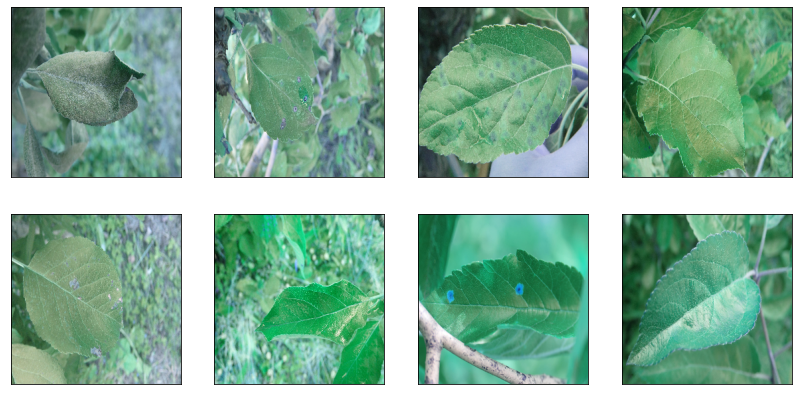

In [34]:
#Теперь мы хотим написать свой transform'ер. В него будет включен Normalize, поэтому сначала посчитаем mean и std - для этого будем
#использовать другой кастомный датасет.(просто для тренировки, можно нормировать по mean и std из ImageNet)

class DatasetForMean(Dataset):
    def __init__(self, root_dir, csv, transform = None):
        self.transform = transform
        self.root_dir = root_dir
        self.csv = csv
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv.iloc[index, 0])
        image = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        
        
        if self.transform:
            image = self.transform(image = image)["image"]
            
        return image

augs = A.Compose([A.Resize(height = 256, 
                           width  = 256),
                  A.Normalize(mean = (0, 0, 0),
                              std  = (1, 1, 1)),
                  ToTensorV2()])

image_dataset = DatasetForMean(root_dir = "../input/plant-pathology-2021-fgvc8/train_images", 
                         csv = csv,
                         transform = augs)

# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = 8, 
                          shuffle     = False, 
                          num_workers = 4,
                          pin_memory  = True)

# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [35]:
#Пока просто проверили датасет и тестово вывели картинки, теперь к подсчетам
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    ####### FINAL CALCULATIONS

# pixel count PS. image_size указываем тот, который был в transform выше
image_size = 256
count = len(csv) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|██████████| 2329/2329 [17:46<00:00,  2.18it/s]

mean: tensor([0.4077, 0.6261, 0.4868])
std:  tensor([0.1962, 0.1652, 0.1883])


In [68]:
#Теперь, зная mean и std можем делать свой transform'ер 
my_transforms = transforms.Compose([
    transforms.Resize((170, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4077, 0.6261, 0.4868], std=[0.1962, 0.1652, 0.1883])
])

In [ ]:
#Для val dataset'a (и в будущем для test dataset'a)
my_transforms_val = transforms.Compose([
    transforms.Resize((170, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4077, 0.6261, 0.4868], std=[0.1962, 0.1652, 0.1883])
])

In [69]:
#Создадим датасеты и применим наш трансформ (для val датасета без аугментации)
train_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_train, transform = my_transforms)
val_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_val, transform = my_transforms_val)

In [55]:
#Здесь можем посмотреть как выглядит одна картинка с нашей нормализацией
img = Image.open("../input/resized-plant2021/img_sz_256/800113bb65efe69e.jpg")

preprocess = transforms.Compose([
    transforms.Resize((170, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4077, 0.6261, 0.4868], std=[0.1962, 0.1652, 0.1883])
])

x = preprocess(img)
x.shape

torch.Size([3, 170, 256])

In [56]:
#Сразу переводить тенсор в numpy.array и визуализировать не получится, нужно сделать чтобы значения были [0:1]. Эта функция линейно преобразует и делает то что нам как раз и нужно 
def renormalize(tensor):
        minFrom= tensor.min()
        maxFrom= tensor.max()
        minTo = 0
        maxTo=1
        return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))
x = renormalize(x)

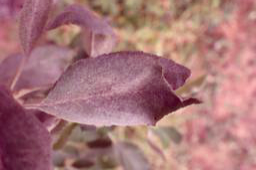

In [57]:
#Выведем картинку
transform = transforms.ToPILImage()
img = transform(x)
img

In [70]:
#теперь приступим к построению CNN (построили с BatchNorm и MaxPool) 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 42, kernel_size = 4, stride = 2)
        self.bn1 = nn.BatchNorm2d(42)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=42, out_channels=100, kernel_size=4)
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=3, stride = 2)
        self.bn3 = nn.BatchNorm2d(200)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=6)
        self.bn4 = nn.BatchNorm2d(200)
        self.pool4 = nn.MaxPool2d(kernel_size=6, stride=1)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(200 * 15 * 5, 512)  # !!!
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 12)
        
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        
        #print(x.shape)
        
        x = x.view(-1, 200 * 15 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
#Тут проверяем shape на выходе из CNN чтобы передать в FCN
model = CNN()
model(train_dataset[0][0].view(1, 3, 170, 256))

torch.Size([1, 200, 5, 15])


In [71]:
#Создаем лоадеры
trainloader = DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True)
valloader = DataLoader(dataset = val_dataset, batch_size = 128, shuffle = True)

In [72]:
#Процесс обучения (очень долгий т.к. ресайзятся все картинки - нужно сделать это заранее и создать новый датасет (в данном случае нашел уже готовый)
#Модель учится - это видно по лоссам на валидации. Видно, что нужно больше итераций, но сейчас нет смысла тратить время.
# + добавили процесс запоминания лучшей модели, а также сохранения ошибок по эпохам для дальнейшей отрисовки
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
num_epochs = 50

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            
            preds = torch.argmax(probs, -1)
            running_corrects += int(torch.sum(preds == target.data))
            
        val_loss = running_loss1 / processed_size1 
        val_acc = running_corrects / processed_size1 
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc))
    scheduler.step()

100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Epoch 0: train_loss:25.009218198889673 val_loss:1.8163331854021227


100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Epoch 1: train_loss:1.7933439157809388 val_loss:1.7489729272997057


100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch 2: train_loss:1.7843390698091868 val_loss:1.7276539332157856


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 3: train_loss:1.7401579689666602 val_loss:1.6993134853002188


100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


Epoch 4: train_loss:1.6939980815123081 val_loss:1.727217712144594


100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


Epoch 5: train_loss:1.5567040564449932 val_loss:1.48233412381765


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 6: train_loss:1.4864628091434546 val_loss:1.5068770448581592


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 7: train_loss:1.4702214877279074 val_loss:1.3962203708854881


100%|██████████| 29/29 [00:12<00:00,  2.27it/s]


Epoch 8: train_loss:1.418110689528021 val_loss:1.4709787489916828


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 9: train_loss:1.408824145746014 val_loss:1.4038084378113618


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 10: train_loss:1.3861322015276423 val_loss:1.3594212825878247


100%|██████████| 29/29 [00:13<00:00,  2.19it/s]


Epoch 11: train_loss:1.3707518117088688 val_loss:1.3362292079667788


100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


Epoch 12: train_loss:1.3317461104166912 val_loss:1.3140579633455018


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch 13: train_loss:1.3281346883015055 val_loss:1.288456148199133


100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Epoch 14: train_loss:1.3294545375020261 val_loss:1.2778191599974762


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 15: train_loss:1.2943477809445136 val_loss:1.3314491005201599


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch 16: train_loss:1.3000459549990986 val_loss:1.2799571548925863


100%|██████████| 29/29 [00:12<00:00,  2.28it/s]


Epoch 17: train_loss:1.2696747110830757 val_loss:1.2524072761793394


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch 18: train_loss:1.2630166676291632 val_loss:1.2618937790071643


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 19: train_loss:1.2552610352822995 val_loss:1.2386291333791373


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 20: train_loss:1.2205983405773613 val_loss:1.2401900848182472


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


Epoch 21: train_loss:1.2178872553234985 val_loss:1.3116930126499486


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 22: train_loss:1.2123893583999255 val_loss:1.187743104084118


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch 23: train_loss:1.1847462870945025 val_loss:1.2033437647690644


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Epoch 24: train_loss:1.2159074867119777 val_loss:1.1652524967451354


100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


Epoch 25: train_loss:1.1659310145381945 val_loss:1.16699144092766


100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


Epoch 26: train_loss:1.1373151812833147 val_loss:1.1260834657823717


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 27: train_loss:1.1315231927751122 val_loss:1.1165788689175167


100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


Epoch 28: train_loss:1.1247706775399593 val_loss:1.1592352673814104


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch 29: train_loss:1.1081745088052533 val_loss:1.0769633974255741


100%|██████████| 29/29 [00:13<00:00,  2.12it/s]


Epoch 30: train_loss:1.0649230257295395 val_loss:1.1102981941120045


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


Epoch 31: train_loss:1.0614974325986322 val_loss:1.1152793648436263


100%|██████████| 29/29 [00:14<00:00,  2.07it/s]


Epoch 32: train_loss:0.9894444632715429 val_loss:1.0504145808477658


100%|██████████| 29/29 [00:13<00:00,  2.20it/s]


Epoch 33: train_loss:0.9726482872473724 val_loss:0.9607154350667386


100%|██████████| 29/29 [00:13<00:00,  2.19it/s]


Epoch 34: train_loss:0.9307918205613781 val_loss:0.9977571998415766


100%|██████████| 29/29 [00:13<00:00,  2.13it/s]


Epoch 35: train_loss:0.900483144086454 val_loss:0.9436983243839161


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 36: train_loss:0.904441859586099 val_loss:0.954311180243621


100%|██████████| 29/29 [00:13<00:00,  2.11it/s]


Epoch 37: train_loss:0.8814542914343813 val_loss:0.9535524293538686


100%|██████████| 29/29 [00:13<00:00,  2.18it/s]


Epoch 38: train_loss:0.8787169810629006 val_loss:0.9171171054324588


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 39: train_loss:0.8664057490623192 val_loss:0.9343330520552557


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 40: train_loss:0.8369058629254889 val_loss:0.8673244205036679


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 41: train_loss:0.8258144762411918 val_loss:0.9190905059994878


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch 42: train_loss:0.8246180194490179 val_loss:0.9061383068239367


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 43: train_loss:0.8277356311810614 val_loss:0.8508922599457406


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Epoch 44: train_loss:0.8095129645768101 val_loss:0.8461209480182544


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 45: train_loss:0.7789392203707303 val_loss:0.8136199758503888


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Epoch 46: train_loss:0.7680451694647429 val_loss:0.7997521926905657


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Epoch 47: train_loss:0.7599657126192174 val_loss:0.8082667528616415


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


Epoch 48: train_loss:0.7666495380438655 val_loss:0.8987376603564701


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

Epoch 49: train_loss:0.7447365451651031 val_loss:0.8435764440330299


In [ ]:
#Тут можно вывести график ошибок на train и val, все что нужно - сохранять в список после каждой эпохи train_loss и val_loss и номер эпохи
#Тут надо предиктить и проверять качество на реальных данных, однако контест в формате Code Competition, поэтому теста нет
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
#Тут с кросс-валидацией (затратно по времени, в данном случае остановимся просто на использовании отложенной выборки)
#Тут просто baseline, нужно чуть редактировать под себя
splits=KFold(n_splits=5,shuffle=True,random_state=42)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=128, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = ConvNet()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,'k_cross_CNN.pt')    

In [ ]:
#Также можно поподбирать гиперпараметры через optuna (https://pub.towardsai.net/tuning-pytorch-hyperparameters-with-optuna-470edcfd4dc)